Experiment No 3: Machine learning Minor
Decison tree Build up and comparison with KNN
Try to run following code and follow up the exercise given below.

## Synthetic Data

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


It took 0.8170367869999922 seconds to complete the shading with a DT
It took 10.503035982 seconds to complete the shading with kNN
DTs get faster compared to kNN as number of training points increases - set n = 500 and see


<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


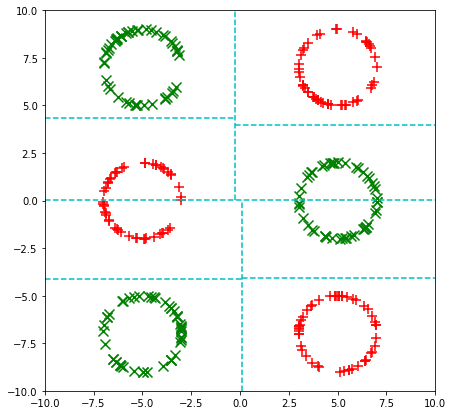

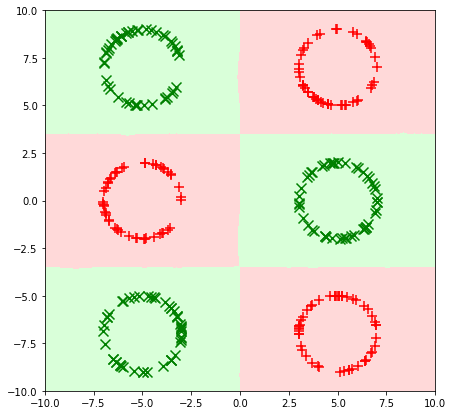

In [ ]:
import numpy as np
from numpy import linalg as lin
import genSyntheticData as gsd
import plotData as pd
from matplotlib import pyplot as plt
import time as t

class Node:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            if data[self.stump[0]] > self.stump[1]:
                return self.right.predict( data )
            else:
                return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
            
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary 
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
                candidateObjective = 0.0 * 0.0 \
                                    + 1.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                    + 1.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
                if candidateObjective < bestObjective:
                    bestObjective = candidateObjective
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
        
        # Can try LwP decision stump as well
        bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        return (bestFeat, bestThresh)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            self.label = np.mean( y )
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = Node( depth = self.depth + 1, parent = self )
            self.right = Node( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = X[:, self.stump[0]] - self.stump[1]
            # Train my two children recursively
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

class Tree:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = Node()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt, yt ):
        return self.root.predict( np.array( [xt, yt] ) )
    
    def train( self, X, y ):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

d = 2 
n = 50
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

DT = Tree( maxLeafSize = 5, maxDepth = 4 )
DT.train( X, y )

def drawTreeSplits( node, fig, xlim, ylim ):
    if not node.isLeaf:
        plt.figure( fig.number )
        # Is this a vertical split or a horizontal one?
        if node.stump[0] == 0:
            plt.plot( [node.stump[1], node.stump[1]], ylim, color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, [xlim[0], node.stump[1]], ylim )
            drawTreeSplits( node.right, fig, [node.stump[1], xlim[1]], ylim )
        elif node.stump[0] == 1:
            plt.plot( xlim, [node.stump[1], node.stump[1]], color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, xlim, [ylim[0], node.stump[1]] )
            drawTreeSplits( node.right, fig, xlim, [node.stump[1], ylim[1]] )
            
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = lin.norm( diff, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

fig = pd.getFigure()
tic = t.process_time()
pd.shade2D( DT.predict, fig, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with a DT")
drawTreeSplits(DT.root, fig, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig, color = 'r', marker = '+' )
pd.plot2D( XPos, fig, color = 'g', marker = 'x' )

k = 1
fig2 = pd.getFigure()
tic = t.process_time()
pd.shade2D( kNNClass, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with kNN")
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )
print( "DTs get faster compared to kNN as number of training points increases - set n = 500 and see" )

## Problem

1. Can you change the DT to use information gain instead of Gini impurity for the criterion split
2. Can you use the DT learning code given here to train a DT with this dataset ([link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29))?
3. Experiment with the tree hyperparameters using cross-validation to see what sort of tree works best for this dataset.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data=pd.read_csv('/content/breast_cancer_data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
columns=data.columns
columns=columns[1:-1]
print(columns)

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [ ]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [ ]:
data['diagnosis'].replace(['B', 'M'], [0, 1], inplace=True)

In [ ]:
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [ ]:
data.drop(['Unnamed: 32'], axis=1, inplace=True)

In [ ]:
data.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
datavar = pd.DataFrame(data, columns=['id','radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'])

target=data['diagnosis']

In [ ]:
X = datavar
y = target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [ ]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9473684210526315


In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X, y)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=15,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(datavar, target);


Fitting 15 folds for each of 32 candidates, totalling 480 fits


In [ ]:
gs_DT.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [ ]:
gs_DT.best_score_

0.9385490753911807

In [ ]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns


Index(['criterion', 'max_depth', 'min_samples_split', 'test_score'], dtype='object')

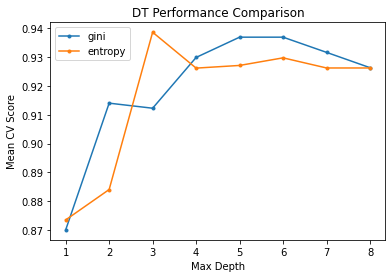

In [ ]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6, min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9385964912280702
